In [135]:
import numpy as np
import warnings

warnings.filterwarnings("ignore")

def simulate_data(n):
    np.random.seed(1)
    beta = np.array([2, 1.5, 1, 0.5])
    X = np.random.randn(n, 4)
    epsilon = np.random.randn(n)
    y = X.dot(beta) + epsilon
    return X, y

# Simulation parameters
n_train = 10000
n_val = 5000
n_test = 100000

# Simulating data for training, validation, and test sets
X_train, y_train = simulate_data(n_train)
X_val, y_val = simulate_data(n_val)
X_test, y_test = simulate_data(n_test)

correlation_matrix = np.corrcoef(X_train, rowvar=False)

# Printing correlation matrix
print("Correlation Matrix of X:")
print(correlation_matrix)

Correlation Matrix of X:
[[ 1.         -0.01358966 -0.00496157 -0.00209572]
 [-0.01358966  1.         -0.00917093 -0.02053692]
 [-0.00496157 -0.00917093  1.         -0.00898957]
 [-0.00209572 -0.02053692 -0.00898957  1.        ]]


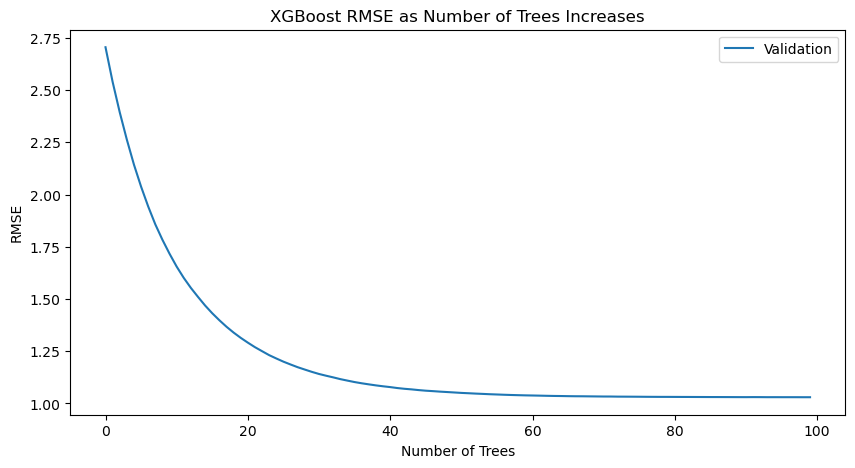

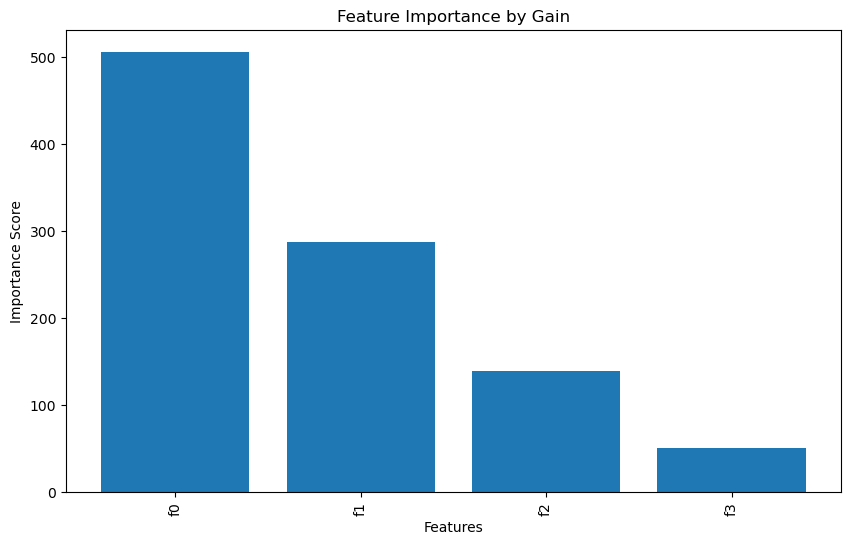

R² on test set: 0.8742
Optimal number of trees: 100


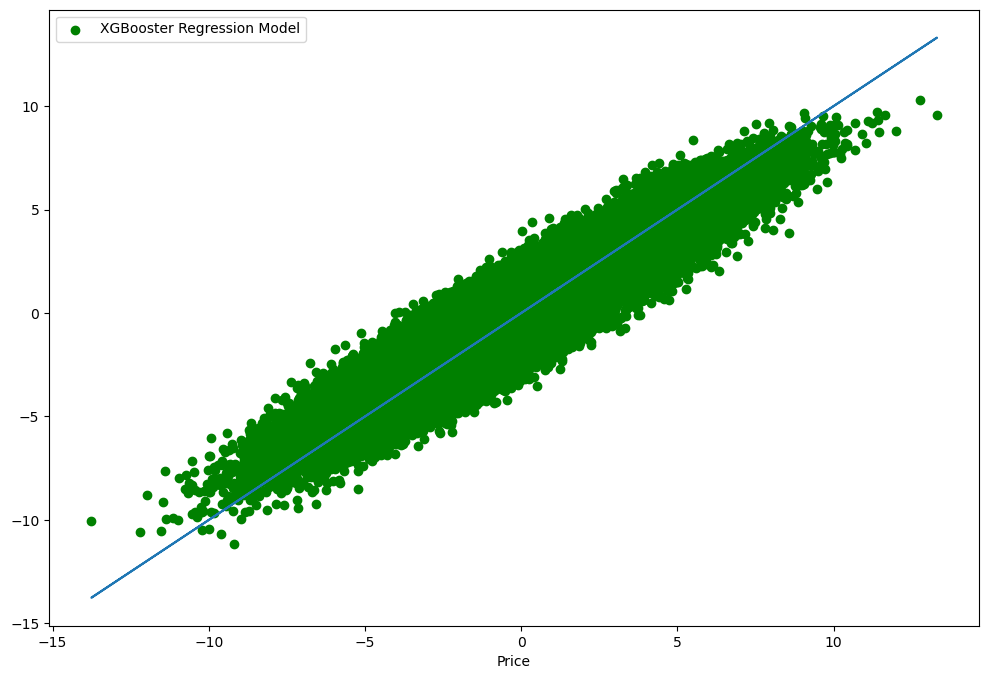

In [136]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
np.random.seed(1)

def fit_xgboost_and_plot(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate=0.1, max_depth=4,num_rounds = 200):

    model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=learning_rate, max_depth=max_depth)
    model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose=False, early_stopping_rounds=100)
    
    # Get the best number of trees based on early stopping
    optimal_trees = model.best_iteration + 1  # Adding 1 because iterations are zero-indexed
    
    # Get the RMSE values for each iteration from the evaluation results
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    
    # Plot RMSE against iterations
    plt.figure(figsize=(10, 5))
    #plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
    plt.plot(x_axis, results['validation_0']['rmse'], label='Validation')
    plt.legend()
    plt.ylabel('RMSE')
    plt.xlabel('Number of Trees')
    plt.title('XGBoost RMSE as Number of Trees Increases')
    plt.show()
    import pandas as pd

    # Get feature importance data
    importance = model.get_booster().get_score(importance_type='gain')

    # Create a DataFrame for easier handling
    df_importance = pd.DataFrame({
        'Feature': importance.keys(),
        'Importance': importance.values()
    }).sort_values(by='Importance', ascending=False)

    # Plotting directly
    plt.figure(figsize=(10, 6))
    plt.bar(df_importance['Feature'], df_importance['Importance'])
    plt.title('Feature Importance by Gain')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=90)
    plt.show()

    # Predictions on test set using the optimal number of trees
    y_pred = model.predict(X_test, iteration_range=(0, model.best_iteration + 1))

    # Calculate R-squared on test set
    r2 = r2_score(y_test, y_pred)
    print(f'R² on test set: {r2:.4f}')
    print(f'Optimal number of trees: {optimal_trees}')

    plt.figure(figsize=(12,8))
    plt.plot(y_test,y_test)
    plt.scatter(y_test,y_pred, color = 'g', label = 'XGBooster Regression Model')
   # plt.scatter(y_test,y_pred1, color = 'r', label = 'Linear Regression Model')
    plt.xlabel('Price')
    plt.legend()
    
    # Return the model, R², and optimal number of trees
    return model, r2, optimal_trees

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are already defined as per your previous script
model, r_squared, optimal_trees = fit_xgboost_and_plot(X_train, y_train, X_val, y_val, X_test, y_test)


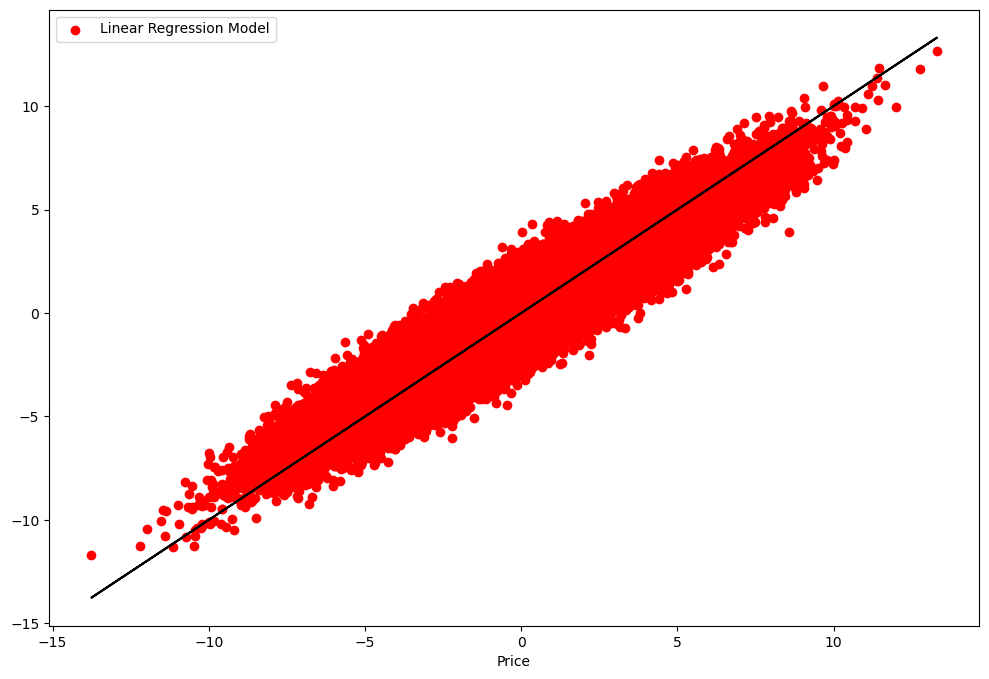

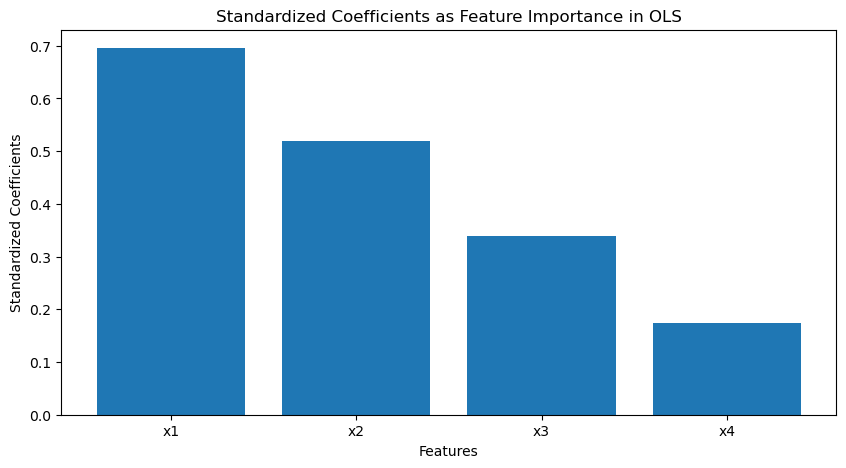

OLS RMSE on test set: 0.9990
OLS R² on test set: 0.8822
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 1.814e+04
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:35:13   Log-Likelihood:                -14231.
No. Observations:               10000   AIC:                         2.847e+04
Df Residuals:                    9995   BIC:                         2.851e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [137]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

def fit_ols_and_evaluate(X_train, y_train, X_test, y_test):
    
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    
    model = sm.OLS(y_train, X_train_sm).fit()
    
    y_pred1 = model.predict(X_test_sm)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred1))
    
    r2 = r2_score(y_test, y_pred1)
    
    plt.figure(figsize=(12,8))
    plt.plot(y_test,y_test,color ='black')
    #plt.scatter(y_test,y_pred1, color = 'g', label = 'XGBooster Regression Model')
    plt.scatter(y_test,y_pred1, color = 'r', label = 'Linear Regression Model')
    plt.xlabel('Price')
    plt.legend()
    plt.show()
    
    
    std_devs = np.std(X_train, axis=0)
    std_dev_y = np.std(y_train)
    standardized_coefs = model.params[1:] * (std_devs / std_dev_y)  # Skip the intercept

    # Plotting the standardized coefficients
    features = ['x1', 'x2', 'x3', 'x4'] if X_train.shape[1] == 4 else ['x1', 'x2', 'x3', 'x4', 'x5']
    plt.figure(figsize=(10, 5))
    plt.bar(features, standardized_coefs)
    plt.xlabel('Features')
    plt.ylabel('Standardized Coefficients')
    plt.title('Standardized Coefficients as Feature Importance in OLS')
    plt.show()
    print(f"OLS RMSE on test set: {rmse:.4f}")
    print(f"OLS R² on test set: {r2:.4f}")
    print(model.summary())
    return model.summary()

ols_summary = fit_ols_and_evaluate(X_train, y_train, X_test, y_test)


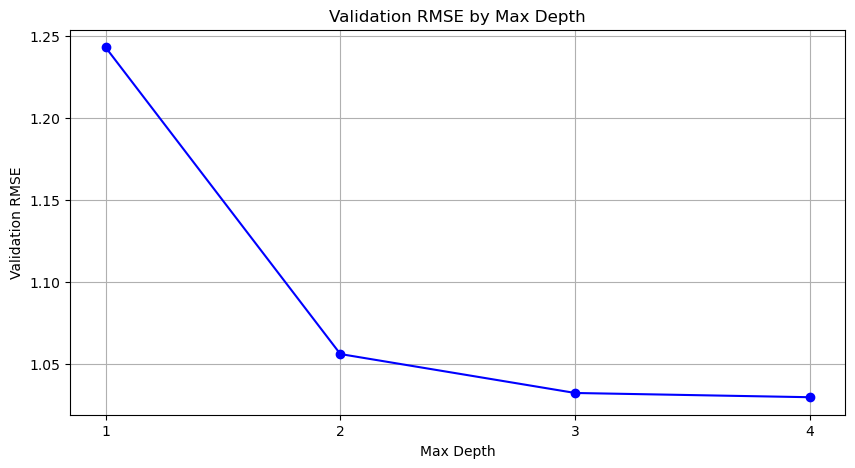

[1.2430387013467217, 1.0559577912471945, 1.0322152767339836, 1.0296306846222347]


In [105]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def validate_max_depth(X_train, y_train, X_val, y_val, depths, learning_rate=0.1):
    rmse_scores = []
    
    # Loop over specified max_depth values
    for depth in depths:
        model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=learning_rate, max_depth=depth, seed=1)
        eval_set = [(X_val, y_val)]
        
        # Fit model and evaluate on validation set
        model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
        
        # Get the last RMSE value from the validation set (end of training)
        rmse = model.evals_result()['validation_0']['rmse'][-1]
        rmse_scores.append(rmse)
    
    # Plotting the RMSE values for each max_depth
    plt.figure(figsize=(10, 5))
    plt.plot(depths, rmse_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Max Depth')
    plt.ylabel('Validation RMSE')
    plt.title('Validation RMSE by Max Depth')
    plt.xticks(depths)
    plt.grid(True)
    plt.show()

    return rmse_scores

# Define the range of max_depth values to test
depths = [1, 2, 3, 4]

# Assuming X_train, y_train, X_val, y_val are already defined
rmse_scores = validate_max_depth(X_train, y_train, X_val, y_val, depths)
print(rmse_scores)

In [106]:
import numpy as np

def log_transform_data(X, y):
    # Applying a small shift before taking logarithms to avoid log(0)
    X_transformed = np.log(X + 15)
    y_transformed = np.log(y + 15)
    return X_transformed, y_transformed

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are as defined earlier
X_train_log, y_train_log = log_transform_data(X_train, y_train)
X_val_log, y_val_log = log_transform_data(X_val, y_val)
X_test_log, y_test_log = log_transform_data(X_test, y_test)


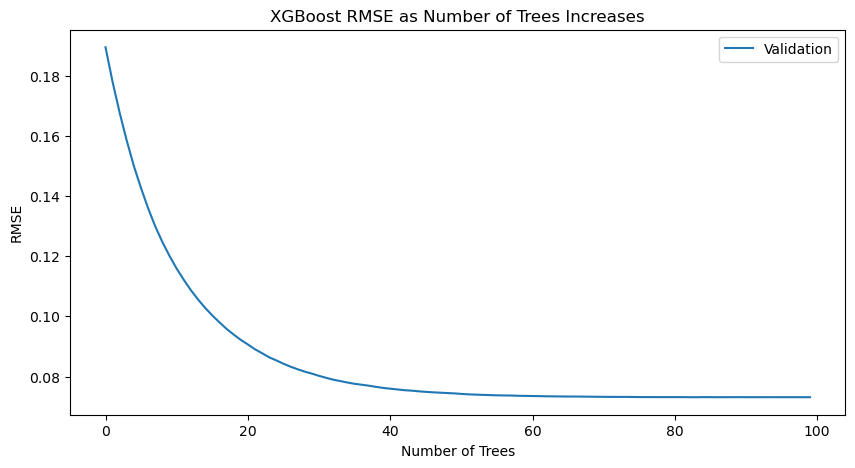

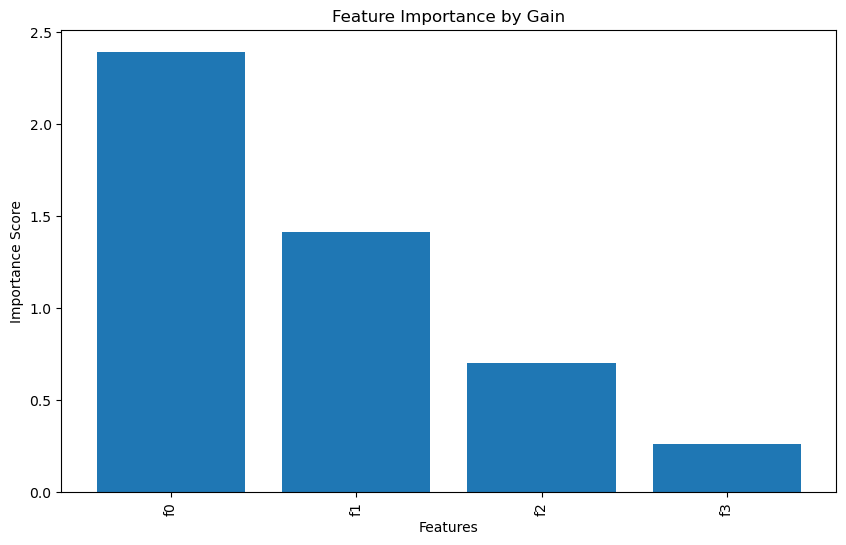

R² on test set: 0.8687
Optimal number of trees: 84


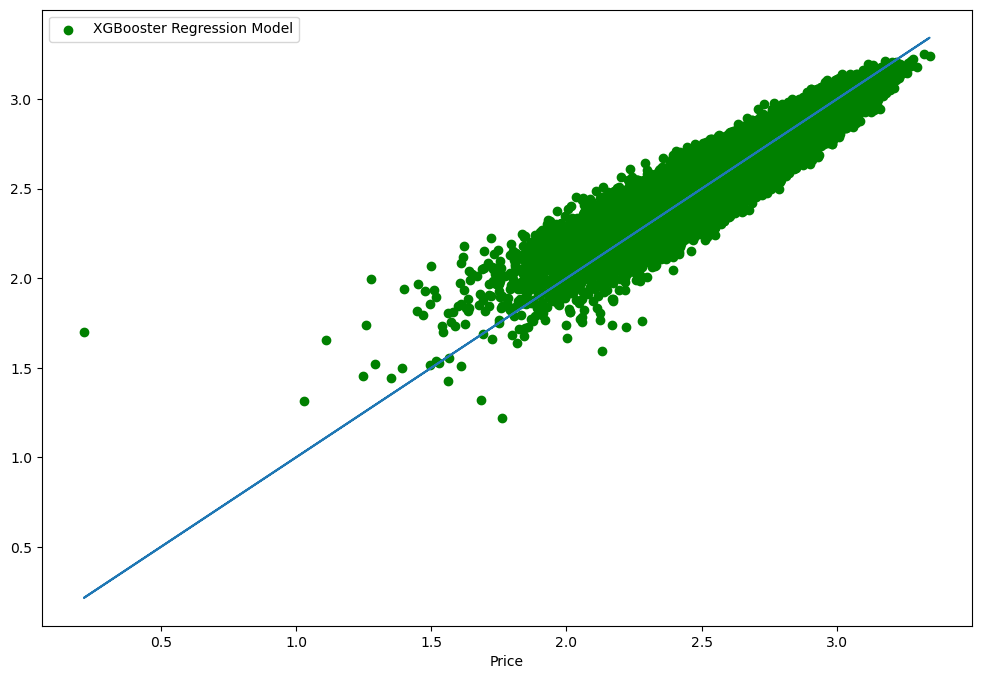

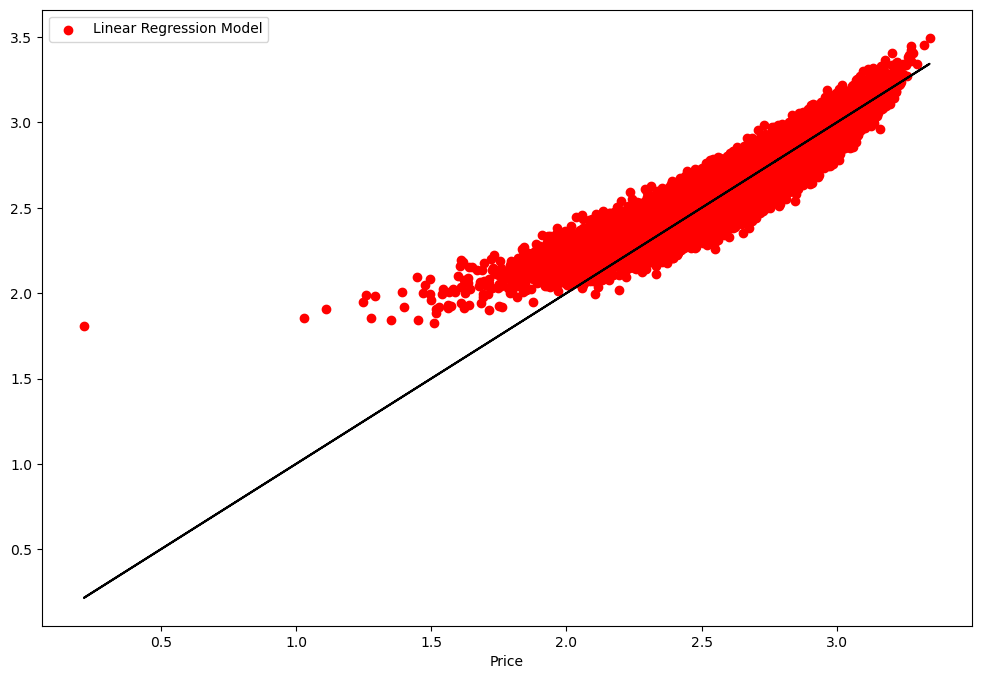

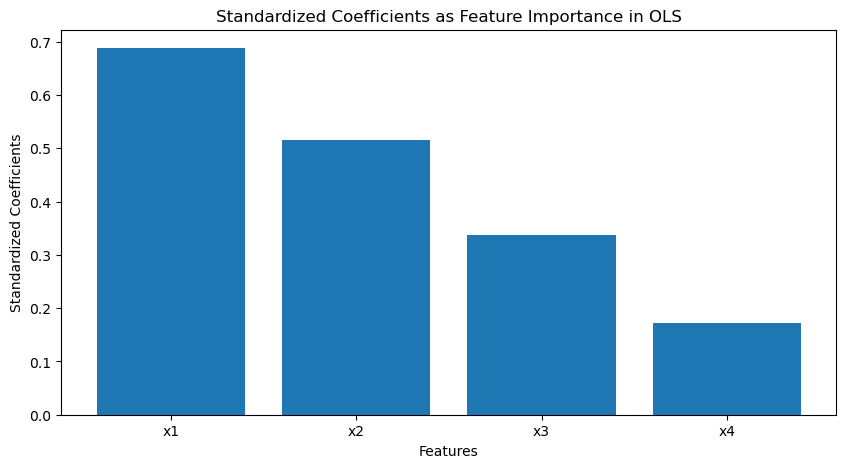

OLS RMSE on test set: 0.0749
OLS R² on test set: 0.8661


In [107]:
model, r_squared, optimal_trees = fit_xgboost_and_plot(X_train_log, y_train_log, X_val_log, y_val_log, X_test_log, y_test_log)
ols_summary = fit_ols_and_evaluate(X_train_log, y_train_log, X_test_log, y_test_log)


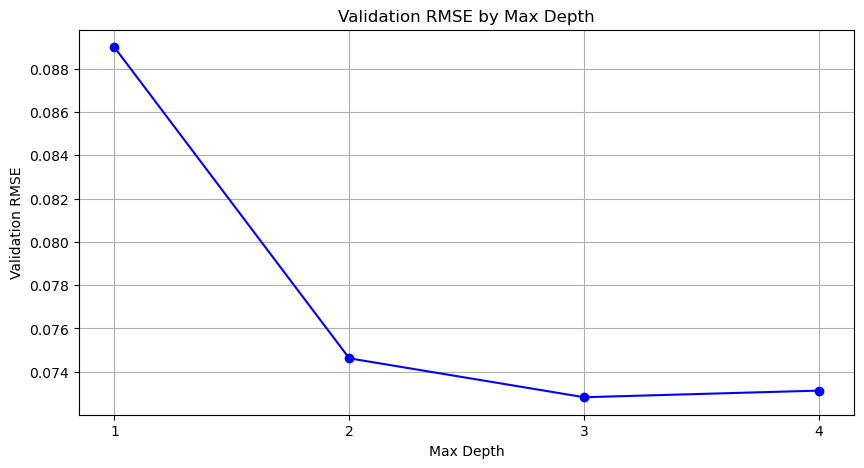

[0.08898688857700134, 0.07461961091598704, 0.07282225077476123, 0.07312764919328661]


In [108]:
rmse_scores = validate_max_depth(X_train_log, y_train_log, X_val_log, y_val_log, depths=[1, 2, 3, 4])
print(rmse_scores)

In [109]:
import numpy as np

def adjust_data(X):
    X_modified = X.copy()
    X_modified[:10, 0] = -100  # Set the first 10 elements of the first feature (x1) to -100
    return X_modified

# Assuming X_train is already defined
X_train_modified = adjust_data(X_train)


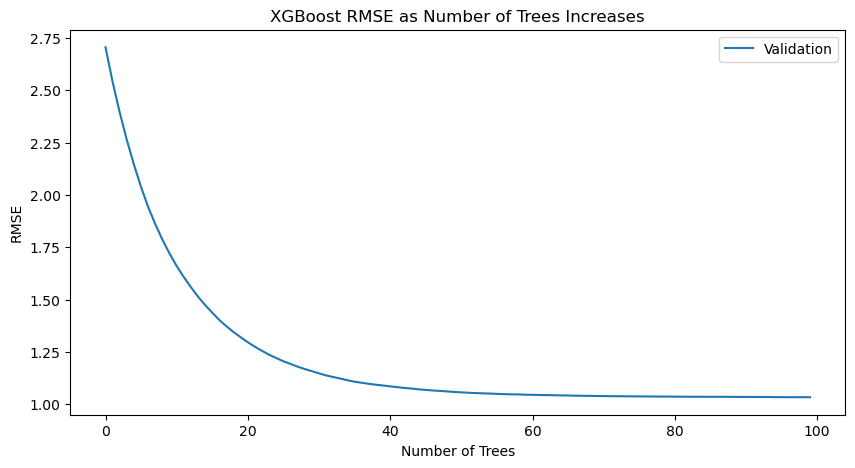

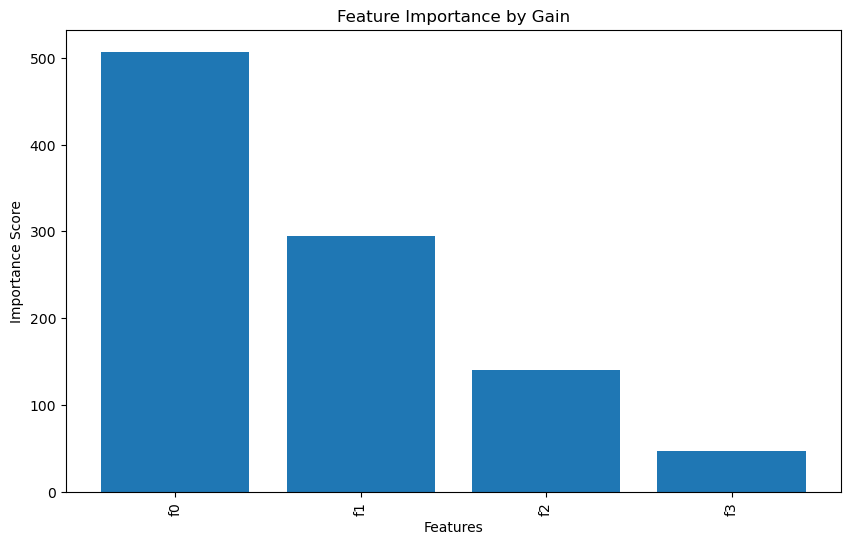

R² on test set: 0.8727
Optimal number of trees: 100


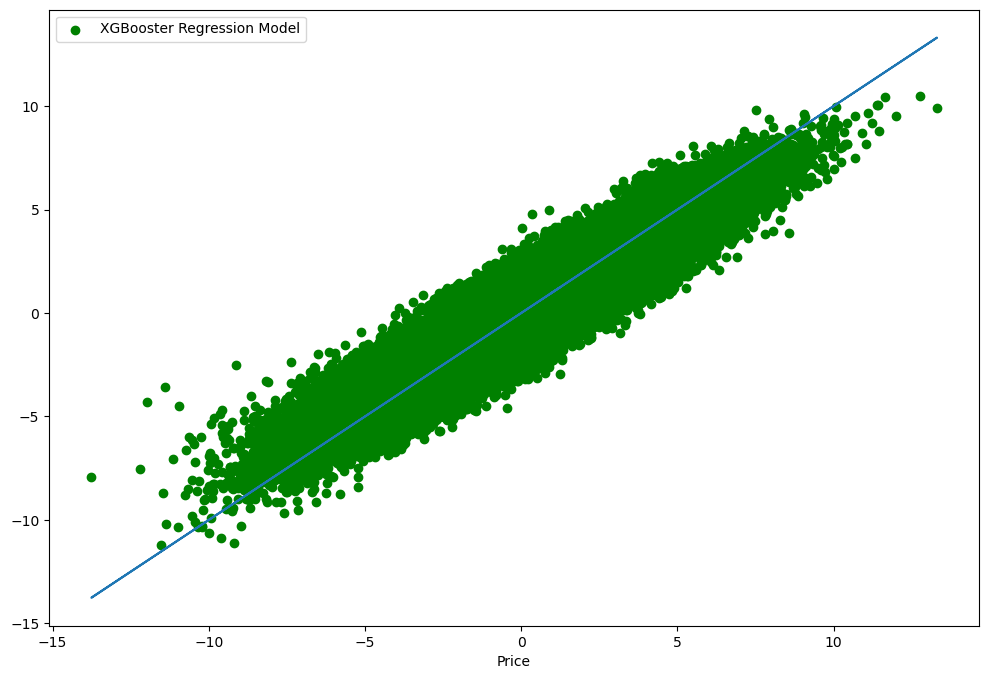

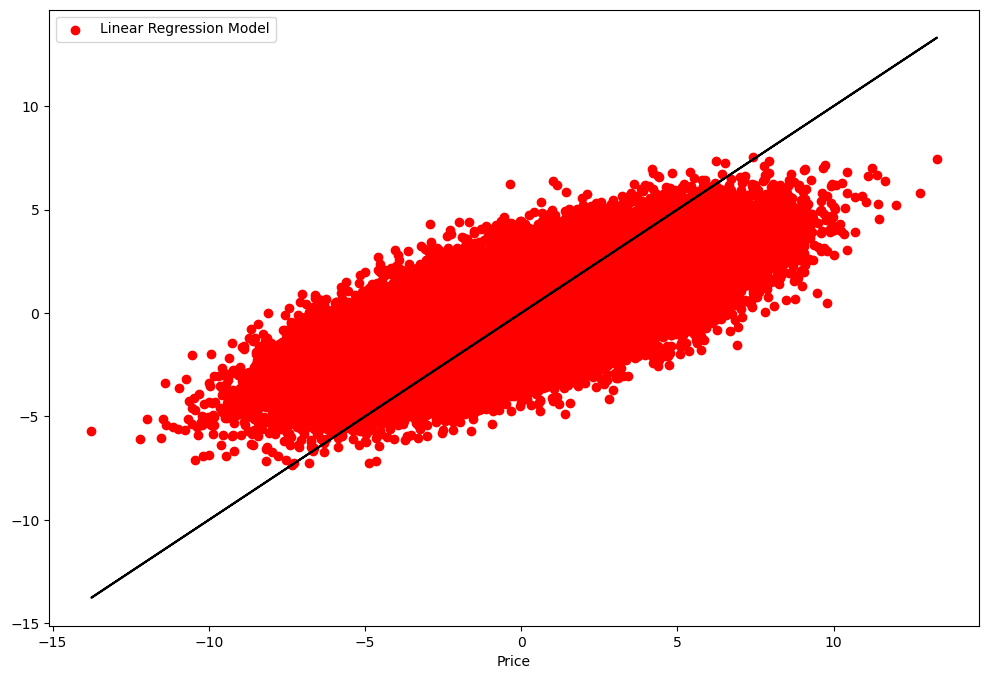

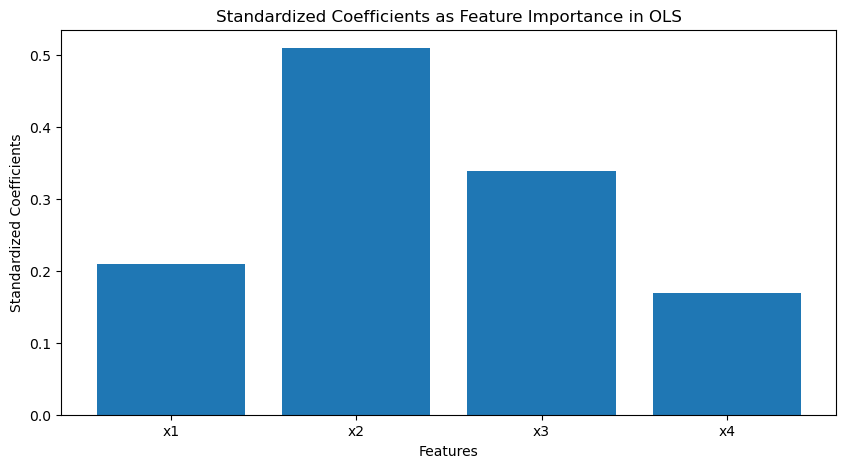

OLS RMSE on test set: 2.0755
OLS R² on test set: 0.4916


In [110]:

# Fit XGBoost and plot RMSE and R² on adjusted data
model_modified, r_squared_modified, optimal_trees_modified = fit_xgboost_and_plot(X_train_modified, y_train, X_val, y_val, X_test, y_test)

# Fit OLS and evaluate on adjusted data
ols_summary_modified = fit_ols_and_evaluate(X_train_modified, y_train, X_test, y_test)


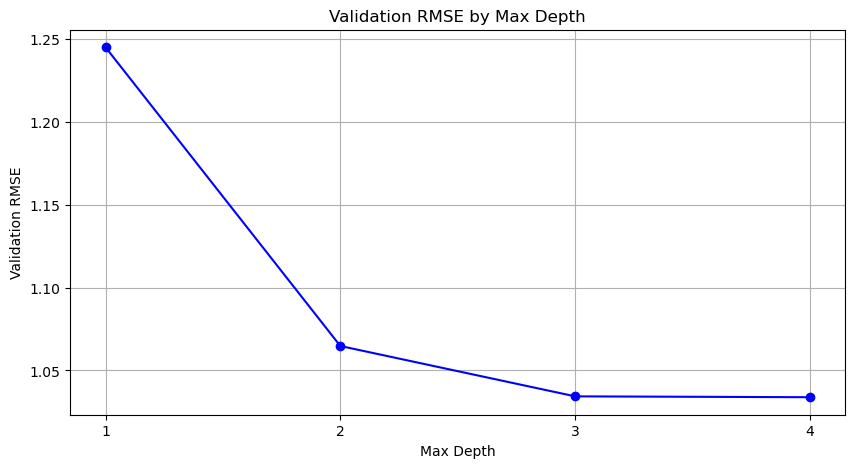

[1.2448476485964914, 1.0647340507248517, 1.0343812873556217, 1.0338572415321428]


In [111]:
rmse_scores_modified = validate_max_depth(X_train_modified, y_train, X_val, y_val, depths=[1, 2, 3, 4])
print(rmse_scores_modified)

In [138]:
import numpy as np

def add_feature(X):
    # Random noise u with mean 0 and variance 0.0012
    u = np.random.normal(0, np.sqrt(0.0012), size=X.shape[0])
    # New feature x5 as x2 - x3 + u
    #epsilon = np.random.randn(X.shape[0])
#    epsilon = np.random.randn(X.shape[0])  # Générer epsilon avec la bonne taille

    x5 = X[:, 1] - X[:, 2] + u #+ epsilon

    # Add this new feature to the existing feature matrix
    X_new = np.column_stack((X, x5))
    return X_new

# Apply the modification to training, validation, and test datasets
X_train_augmented = add_feature(X_train_log)
X_val_augmented = add_feature(X_val_log)
X_test_augmented = add_feature(X_test_log)

correlation_matrix = np.corrcoef(X_train_augmented, rowvar=False)

print("Correlation Matrix of X:")
print(correlation_matrix)


Correlation Matrix of X:
[[ 1.         -0.01427713 -0.00461953 -0.00212298 -0.00942768]
 [-0.01427713  1.         -0.00979113 -0.02023101  0.66520484]
 [-0.00461953 -0.00979113  1.         -0.0088975  -0.6704479 ]
 [-0.00212298 -0.02023101 -0.0088975   1.         -0.00193095]
 [-0.00942768  0.66520484 -0.6704479  -0.00193095  1.        ]]


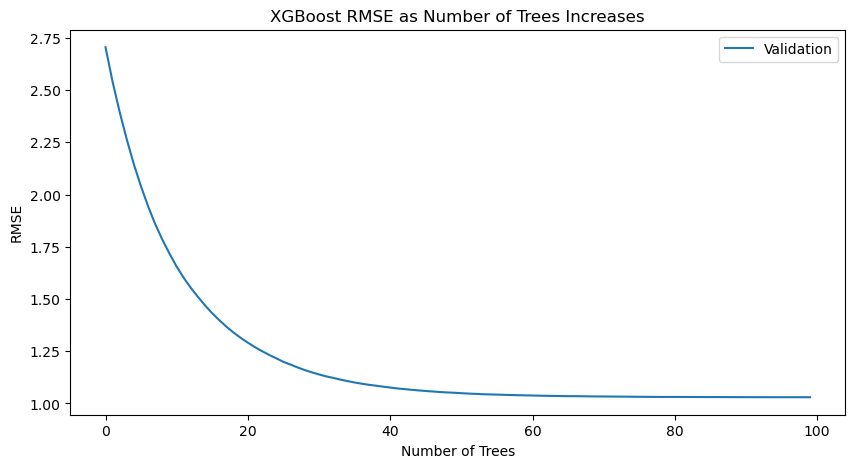

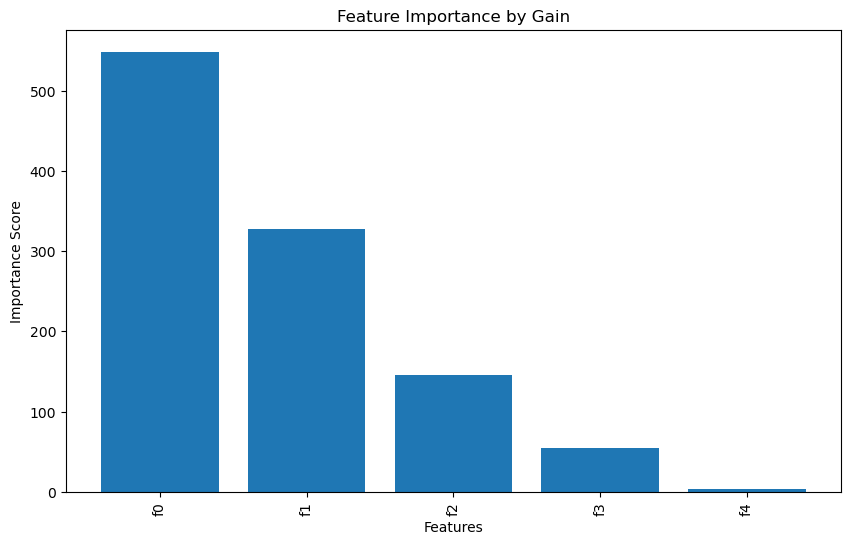

R² on test set: 0.8740
Optimal number of trees: 100


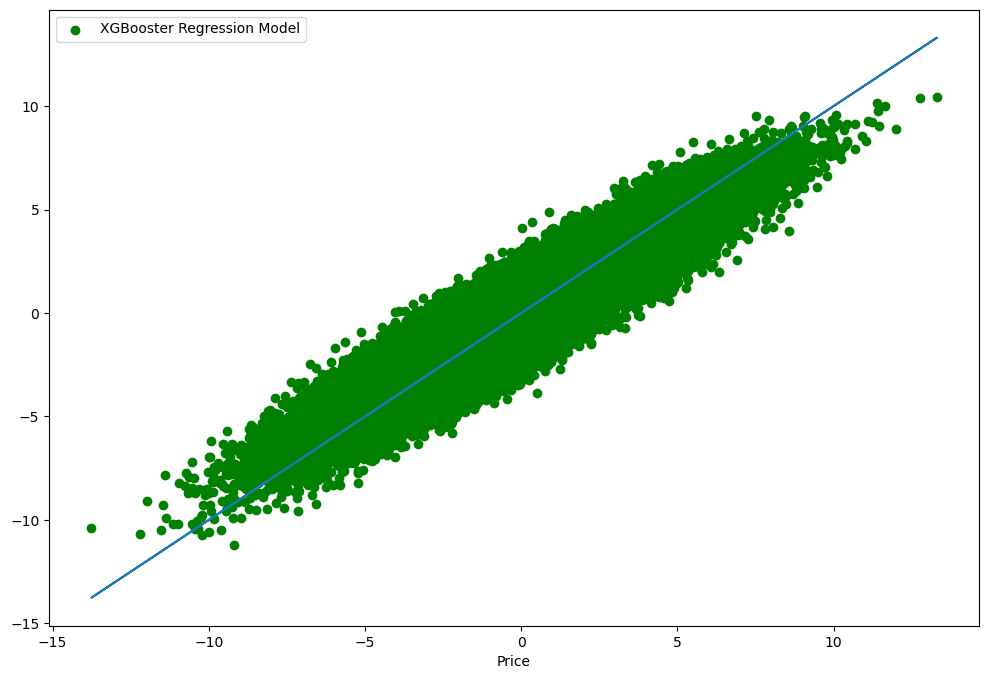

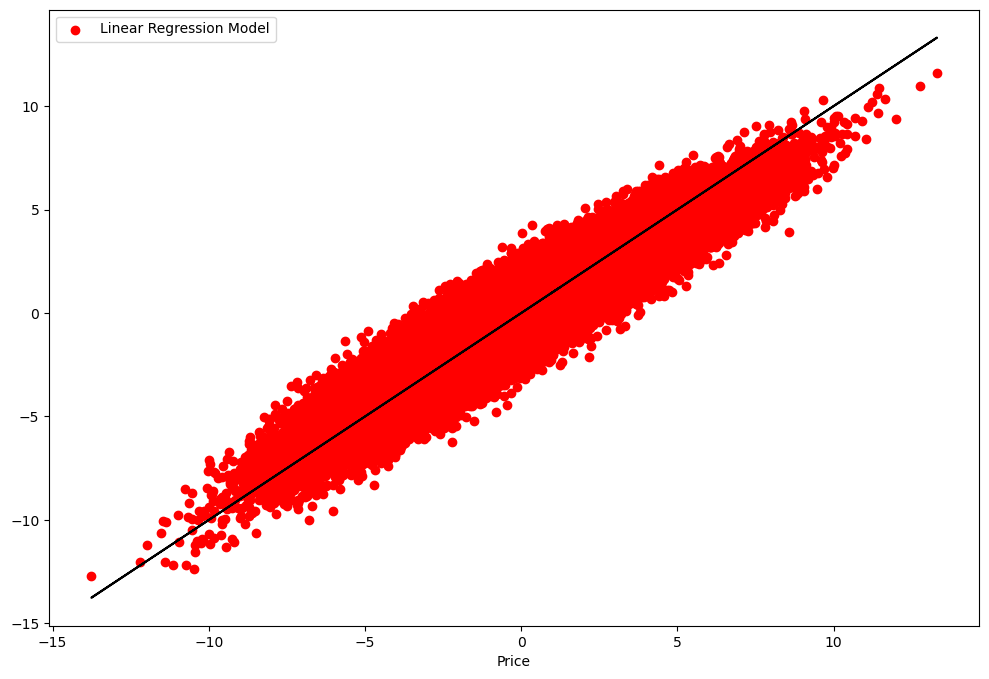

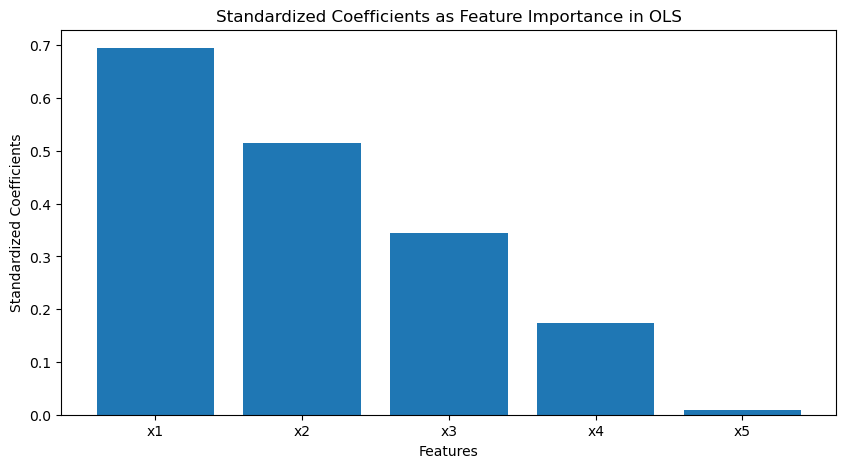

OLS RMSE on test set: 1.0080
OLS R² on test set: 0.8801
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 1.432e+04
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:37:58   Log-Likelihood:                -14290.
No. Observations:               10000   AIC:                         2.859e+04
Df Residuals:                    9994   BIC:                         2.864e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [139]:
model_augmented, r_squared_augmented, optimal_trees_augmented = fit_xgboost_and_plot(X_train_augmented, y_train, X_val_augmented, y_val, X_test_augmented, y_test)
ols_summary_augmented = fit_ols_and_evaluate(X_train_augmented, y_train, X_test_augmented, y_test)


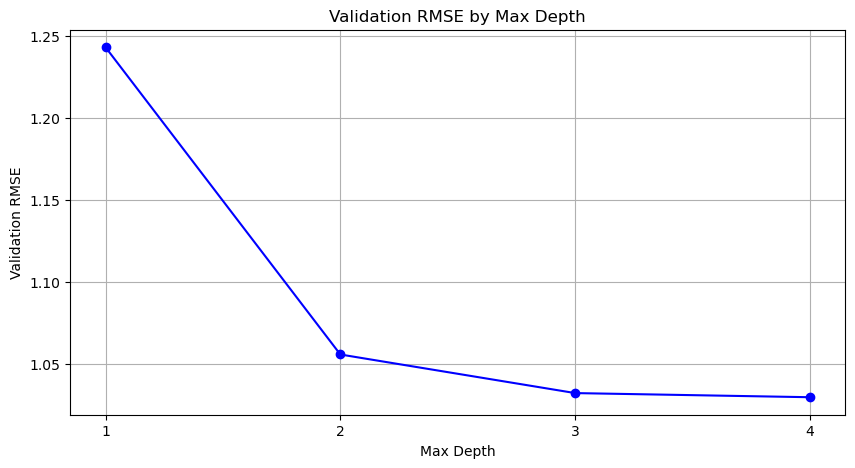

[1.2430387013467217, 1.0559577912471945, 1.032457703820388, 1.0299422722359983]


In [102]:
rmse_scores_augmented = validate_max_depth(X_train_augmented, y_train, X_val_augmented, y_val, depths=[1, 2, 3, 4])
print(rmse_scores_augmented)

In [103]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

def cv_ridge_lasso(X_train, y_train, X_test, y_test):
    alphas = np.logspace(-4, 4, 100)
    
    # Setup RidgeCV
    ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
    ridge_cv.fit(X_train, y_train)
    y_pred_ridge = ridge_cv.predict(X_test)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    r2_ridge = r2_score(y_test, y_pred_ridge)
    
    # Setup LassoCV
    lasso_cv = LassoCV(alphas=alphas, max_iter=10000, cv=5)  # Increased max_iter for convergence
    lasso_cv.fit(X_train, y_train)
    y_pred_lasso = lasso_cv.predict(X_test)
    rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    r2_lasso = r2_score(y_test, y_pred_lasso)
    
    print(f"Optimal Ridge alpha: {ridge_cv.alpha_}")
    print(f"Ridge Regression RMSE: {rmse_ridge:.4f}, R²: {r2_ridge:.4f}")
    
    print(f"Optimal Lasso alpha: {lasso_cv.alpha_}")
    print(f"Lasso Regression RMSE: {rmse_lasso:.4f}, R²: {r2_lasso:.4f}")
    
    return ridge_cv, lasso_cv

ridge_cv_model, lasso_cv_model = cv_ridge_lasso(X_train_augmented, y_train, X_test_augmented, y_test)



Optimal Ridge alpha: 14.849682622544666
Ridge Regression RMSE: 0.9991, R²: 0.8822
Optimal Lasso alpha: 0.0004430621457583882
Lasso Regression RMSE: 0.9990, R²: 0.8822
